# Introduction to this Script

This script uses biopython and matplotlib to process any given pdb, open up the G chain, and plot the H-bonding environment of any given water in that chain

The major dependencies are pandas, matplotlib, itertools, numpy, and biopython. Most of these should already be installed with any Conda build, but if they are not, install them.

In [1]:
%matplotlib notebook
#%matplotlib inline

from Bio.PDB import PDBParser, NeighborSearch, Selection, Vector, vectors
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import math
from mpl_toolkits.mplot3d import proj3d
import pandas as pd
import os

import matplotlib.animation as animation


import warnings
warnings.filterwarnings('ignore')

# Plotter 3D - creating the figure and making the plot

This function takes the coordinates of the target (center) atom, the coordinates of the atoms within H-bonding distance (contact), and the coordinates of the residue and cluster atoms that the contact atoms belong to

Nothing here needs to be modified for the code to be functional, it is up to the user to change visualization styles. 

Notable features:
* the method <code> toggle_images </code> links the appearance of text depicting H-bonding distances on the plot to a toggle key – the default is set to the key "t"
* the block comment at line 174 allows for a rotating image of the plot to be generated and saved as a gif
* the figure can be saved as a png or a jpg by uncommenting line 186

In [2]:
def plotter_3d(contact_atom_coords,center_coord,residue_coords, cluster_coords):
    
    # Set figure size, turn axis off, and set size of viewing window
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection = '3d')
    ax.set_axis_off()
    
    ax.axes.set_xlim3d(left= -3, right= 3) 
    ax.axes.set_ylim3d(bottom= -3 , top= 3) 
    ax.axes.set_zlim3d(bottom= -3, top= 3)
    
    # Generate colormap relating bond distance to color
    
    c = clr.Normalize(2.2,3.5)
    
    mapper = cm.ScalarMappable(norm=c, cmap=cm.cool)
    
    # Plot target water
    
    ax.scatter(0,0,0, color = "tomato",s=300,marker = "P")
    
    # Compute h-bond distances
    
    h_bond_dists = []

    for coord in contact_atom_coords:
        h_bond_dists.append('%.2f'%(math.dist(coord-center_coord,(0,0,0))))
    
    h_bond_dists = np.array(h_bond_dists, dtype=np.float)
    
    # plot h-bonds and color them, establish list of images containing distance labels
    
    h_bond_distance_texts = []
    
    i = 0
    
    for coord in contact_atom_coords:
        
        ax.plot3D([coord[0]-center_coord[0], 0], [coord[1]-center_coord[1], 0], [coord[2]-center_coord[2], 0], 
                  color = clr.to_hex(mapper.to_rgba(h_bond_dists[i])),
                  linestyle = 'dashed')
        
        im = ax.text((coord[0]-center_coord[0])*0.5,(coord[1]-center_coord[1])*0.5, (coord[2]-center_coord[2])*0.5, str(h_bond_dists[i])+'Å')
        
        h_bond_distance_texts.append(im)
        
        i = i+1
    
    #initially hide all h-bond distance labels, then connect their appearance to a keypress 
    
    for h_bond in h_bond_distance_texts:
        h_bond.set_visible(False)
        
    def toggle_images(event):
        'toggle the visible state of the two images'
        if event.key != 't': # press the 't' key on the keyboard to trigger an an event that shows h-bond labels
            return
        
        for hbond in h_bond_distance_texts:
            hbond.set_visible(not hbond.get_visible())
            
        plt.draw()

    plt.connect('key_press_event', toggle_images) 

    # add colorbar on side of figure
    
    plt.colorbar(mapper)
    
    ############################################################################################
    # Plots all the atoms in amino acid residues coordinated to the water molecules
    ############################################################################################

    for key in residue_coords.keys():
        
        # draw atoms in residue and color them based on element
        
        for atom in residue_coords[key]:
            if atom.element == "N":
                ax.scatter(atom.coord[0]-center_coord[0],atom.coord[1]-center_coord[1]
                           ,atom.coord[2]-center_coord[2], s=80, label='True Position',color = 'blue')
            elif atom.element == "O":
                ax.scatter(atom.coord[0]-center_coord[0],atom.coord[1]-center_coord[1]
                           ,atom.coord[2]-center_coord[2], s=80, label='True Position',color = 'red')
            elif atom.element == "C":
                ax.scatter(atom.coord[0]-center_coord[0],atom.coord[1]-center_coord[1]
                           ,atom.coord[2]-center_coord[2], s=80, label='True Position',color = 'black')
            else:
                ax.scatter(atom.coord[0]-center_coord[0],atom.coord[1]-center_coord[1]
                           ,atom.coord[2]-center_coord[2], s=80, label='True Position',color = 'orange')
        
        combinations = []

        for combination in itertools.combinations(residue_coords[key],2):
            combinations.append(combination)

        for atom_pair in combinations:
            
            atom_1_coord = atom_pair[0].coord - center_coord
            atom_2_coord = atom_pair[1].coord - center_coord

            distance = (math.dist(atom_1_coord, atom_2_coord))
            
            # draw bonds between atoms in a residue based on distance
            # if two atoms are within typical single/double bond distance, draw a bond between them
            
            if distance <= 1.56:
                ax.plot3D([atom_1_coord[0]-0.035, atom_2_coord[0]-0.035],
                          [atom_1_coord[1]-0.035, atom_2_coord[1]-0.035],
                          [atom_1_coord[2]-0.035, atom_2_coord[2]-0.035], 'black')

                if 1.32 <= distance <= 1.40:
                    ax.plot3D([atom_1_coord[0]+0.05, atom_2_coord[0]+0.05],
                              [atom_1_coord[1]+0.05, atom_2_coord[1]+0.05],
                              [atom_1_coord[2]+0.05, atom_2_coord[2]+0.05], 'black', linestyle = 'dashed')
                if distance <= 1.25:
                    ax.plot3D([atom_1_coord[0]+0.035, atom_2_coord[0]+0.035],
                              [atom_1_coord[1]+0.035, atom_2_coord[1]+0.035],
                              [atom_1_coord[2]+0.035, atom_2_coord[2]+0.035], 'black')
        #residue labels      
        
        ax.text((residue_coords[key][0].coord-center_coord)[0]+0.2,
            (residue_coords[key][0].coord-center_coord)[1]+0.2,
            (residue_coords[key][0].coord-center_coord)[2]+0.2,str(key))
        
           
    ############################################################################################
    # Plots all the atoms in clusters coordinated to the water molecules
    ############################################################################################      

    for key in cluster_coords.keys():
        
        # draw atoms in the cluster and color them based on element
        
        for atom in cluster_coords[key]:
            if atom.element == "CA":
                ax.scatter(atom.coord[0]-center_coord[0],atom.coord[1]-center_coord[1]
                           ,atom.coord[2]-center_coord[2], s=80, label='True Position',color = 'green')
            elif atom.element == "MN":
                ax.scatter(atom.coord[0]-center_coord[0],atom.coord[1]-center_coord[1]
                           ,atom.coord[2]-center_coord[2], s=80, label='True Position',color = 'purple')
            elif atom.element == "O":
                ax.scatter(atom.coord[0]-center_coord[0],atom.coord[1]-center_coord[1]
                           ,atom.coord[2]-center_coord[2], s=80, label='True Position',color = 'red')
    
        
        cluster_combinations = []

        for combination in itertools.combinations(cluster_coords[key],2):
            cluster_combinations.append(combination)

        for atom_pair in cluster_combinations:
            
            atom_1_coord = atom_pair[0].coord - center_coord
            atom_2_coord = atom_pair[1].coord - center_coord

            distance = (math.dist(atom_1_coord, atom_2_coord))
            
            # draw bonds between atoms in a residue based on distance
            # if two atoms are within typical single/double bond distance, draw a bond between them

            if distance <= 2.6:
                ax.plot3D([atom_1_coord[0]-0.035, atom_2_coord[0]-0.035],
                          [atom_1_coord[1]-0.035, atom_2_coord[1]-0.035],
                          [atom_1_coord[2]-0.035, atom_2_coord[2]-0.035], 'black')
        
        ax.text((cluster_coords[key][0].coord-center_coord)[0]+0.2,
            (cluster_coords[key][0].coord-center_coord)[1]+0.2,
            (cluster_coords[key][0].coord-center_coord)[2]+0.2,str(key))
        
        
    
    ''' 
    # Uncomment this section to generate a rotating gif picture
        
    def rotate(angle):
        ax.view_init(azim=angle)
    
    print("Making animation")
    rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 2), interval=100)
    rot_animation.save('water_150_1F250_rotation.gif', dpi=80, writer='imagemagick')
    
    '''     
    
    #plt.savefig('') # type desired name for pot within empty single quotes
    plt.show()
    

# Processing the PDB

<code> process_pdb </code> takes in a filepath, the target water number, and an excluded conformation to generate a list of potential H-bonding partner names, coordinates, and parent residue/cluster names and coordinates

In [3]:
def process_pdb(filepath,target_atom_id,chain_id,excluded_conformation):
    
    parser = PDBParser()

    structure = parser.get_structure("yup", filepath) # select the file to import

    chain_list = Selection.unfold_entities(structure, "C")

    i = 0
    for chain in chain_list: # figure out the index of the target chain in the pdb
        if chain_id in str(chain):
            chain_index = i
            break
        i = i +1

    chain_atom_list = Selection.unfold_entities(chain_list[chain_index], "A") # creates a list of all atoms in target chain 

    atom_list = Selection.unfold_entities(chain_list, "A") # creates a list of all atoms in all chains
    
    chain_atom_ids = []
    for atom in chain_atom_list: 
        chain_atom_ids.append(atom.get_full_id()[4][0]+"_"+str(atom.get_full_id()[3][1]))
    
    target_atom = chain_atom_list[chain_atom_ids.index(str(target_atom_id))]
    center_coord = target_atom.coord


    residue_coords = {}
    cluster_coords = {}

    # Finds atoms within hydrogen bonding distance to the target atom
    contact_atoms = NeighborSearch(atom_list).search(center = center_coord,radius = 3.5,level = "A")

    # This statement removes the target water itself from being considered a "contact" atom
    contact_atoms = [item for item in contact_atoms if item.coord[0] != center_coord[0] and 
                     item.coord[1] != center_coord[1] and 
                    item.coord[2] != center_coord[2]]   
    
    contact_atoms = [item for item in contact_atoms if item.get_occupancy() != 0]
    
    
    # removes the atoms with excluded conformation - this statement does not apply for pdbs with only one conformation
    contact_atoms = [atom for atom in contact_atoms if atom.get_altloc() != excluded_conformation]
    
    
    for atom in contact_atoms:
        
        atom_conformations = []
        
        if atom.is_disordered() != 0:
            if 'B' in atom_conformations:
                atom.disordered_select('B')
    
    contact_atom_coordinates = []
    contact_atom_name = []

    if len(contact_atoms) > 1:

        for contact in contact_atoms:

            if (contact.get_parent().get_resname() != "OEZ" or contact.get_parent().get_resname() != "OEC"):

                if contact.element == 'O' or contact.element == 'N':

                    contact_atom_coordinates.append(contact.coord)
                    contact_atom_name.append(contact.name+
                                            ' of residue '+contact.get_parent().get_resname()+
                                            " "+str(contact.get_full_id()[3][1]))

                    parent_residue = contact.get_parent()
                    
                    residue_atom_list = []

                    for atom in parent_residue.get_unpacked_list():
                        residue_atom_list.append(atom)
                    
                    for atom in residue_atom_list:

                        atom_conformations = []

                        if atom.is_disordered() != 0:
                            if 'B' in atom_conformations:
                                atom.disordered_select('B')
                    
                    residue_atom_list = [atom for atom in residue_atom_list if atom.get_altloc() != excluded_conformation]

                    # establish the dictionary
                    residue_key = (str(parent_residue.get_unpacked_list()[0].get_full_id()[2])+" "+
                                   str(parent_residue.get_resname())+" " +
                                   str(parent_residue.id[1]))

                    residue_coords[residue_key] = residue_atom_list


            if (contact.get_parent().get_resname() == "OEZ" or contact.get_parent().get_resname() == "OEC"):

                if contact.element == 'O' or contact.element == 'N':

                    contact_atom_coordinates.append(contact.coord)
                    contact_atom_name.append(contact.name+
                                            ' of residue '+contact.get_parent().get_resname()+
                                            " "+str(contact.get_full_id()[3][1]))

                    parent_residue = contact.get_parent()
                    
                    cluster_atoms_list = []

                    for atom in parent_residue.get_unpacked_list():
                        cluster_atoms_list.append(atom)
                        
                    for atom in residue_atom_list:
        
                        atom_conformations = []

                        if atom.is_disordered() != 0:
                            if 'B' in atom_conformations:
                                atom.disordered_select('B')
                    
                    cluster_key = (str(parent_residue.get_unpacked_list()[0].get_full_id()[2])+" "+
                                   str(parent_residue.get_resname())+" " +
                                   str(parent_residue.id[1]))

                    cluster_coords[cluster_key] = cluster_atoms_list

    return contact_atom_name, contact_atom_coordinates, residue_coords, cluster_coords, center_coord


In [4]:
def write_H_bonds(contact_atom_names, contact_atom_coordinates, center_coord):
    
    h_bond_dists = []
    
    dictionary = {}
    
    for coord in contact_atom_coordinates:
        h_bond_dists.append('%.2f'%(math.dist(coord-center_coord,(0,0,0))))
    
    i = 0
    for name in contact_atom_names:
        dictionary["distance to "+name] = float(h_bond_dists[i])
        i = i+1
    
    return dictionary

    

In [5]:
def angle(v1, v2, acute):
# v1 is your first vector
# v2 is your second vector
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
    if (acute == True):
        return angle
    else:
        return 2 * np.pi - angle
    
def bond_angles(contact_atom_coords,center_coord,contact_atom_name):
    
    bond_combinations = []
    bond_angles = []
    atom_combinations = []
    
    for combination in itertools.combinations(contact_atom_coords-center_coord,2):
        bond_combinations.append(combination)
    
    for combination in itertools.combinations(contact_atom_name,2):
        atom_combinations.append(combination)
    
    for combination in bond_combinations:
        bond_angles.append(180*angle(combination[0],combination[1],True)/np.pi)
    
    i = 0
    
    while(i<len(bond_angles)):
        print("the angle between: " + str(atom_combinations[i]) + ' is ' + str(bond_angles[i]))
        i = i +1
    

# Using the Code

The user needs only to provide the name of the pdb file, the location of the pdb file, and the ID of the target water to be used. 

<IPython.core.display.Javascript object>


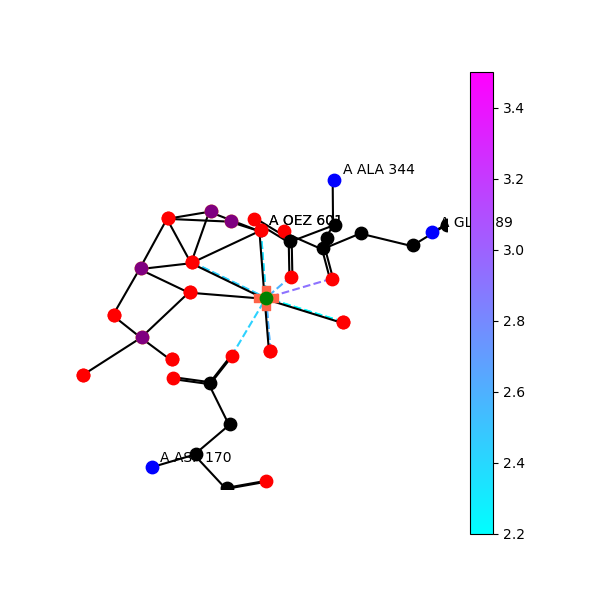

,distance to OD2 of residue ASP 170,distance to OE1 of residue GLU 189,distance to W3 of residue OEZ 601,distance to W4 of residue OEZ 601,distance to O2 of residue OEZ 601,distance to O1 of residue OEZ 601,distance to O of residue ALA 344
0,2.43,2.92,2.59,2.22,2.43,2.36,2.59


In [9]:
filename = "0F.pdb"
filepath = '/Users/albertqiang/Desktop/Yano Lab Work/PDBs/'+filename # change this to reflect your file that contains the pdbs!

target_atom_id = 'CA1_601' # The format of the atom id is as follows: "atom name" + "id of parent residue"
chain_id = "A"

contact_atom_names, contact_atom_coordinates,residue_coords, cluster_coords, center_coord = process_pdb(filepath,target_atom_id,chain_id,"A")


plotter_3d(contact_atom_coordinates, center_coord, residue_coords, cluster_coords)

h_bonds = write_H_bonds(contact_atom_names,contact_atom_coordinates,center_coord)

df = pd.DataFrame(h_bonds, index=[0])

df


#bond_angles(contact_atom_coordinates, center_coord, contact_atom_names) # function that returns all bond angles

